# O código abaixo trata-se do exercício completo. Dado a complexidade da equação, a divisão por itens da questão fica inviável (e feio :B). Portanto, considere que a questão aborda o exercício por completo, incluindo os itens de discussão que o exercício propõe.

# Dado a complexidade, os comentários dentro do codigo visam deixar explícito cada decisão tomada, afim de evitar saltos lógicos

[Truncamento] b ajustado para 4.14e-20 com integral ≈ 1.123771e-81
[Quadratura Gaussiana] Convergiu com n=20 pontos, integral ≈ 1.123771e-81
[Romberg] Convergiu na iteração 1 com valor 8.741984e-82

--- Resultados Finais ---
Limite superior da integral ajustado: b = 4.14e-20 J
Quadratura Gaussiana: integral ≈ 1.123771e-81 J, com 20 pontos
Romberg: integral ≈ 8.741984e-82 J, convergiu na iteração 1
Estimativa de erro final - Quadratura Gaussiana: 2.49e-87
Estimativa de erro final - Romberg: 8.22e-82
Tempo total - Quadratura Gaussiana: 0.0010 segundos
Tempo total - Romberg: 0.0000 segundos

--- Discussão ---
Ambos os métodos convergiram para valores muito próximos, indicando precisão confiável.
A quadratura gaussiana adaptativa usa refinamento no número de pontos para controlar o erro,
enquanto Romberg refina a malha e aplica extrapolação para acelerar convergência.
O erro estimado para ambos é compatível com as tolerâncias escolhidas.
Quanto à eficiência, observe o tempo total de cálcul

C:\Users\gustavo.gimenes\AppData\Local\Temp\ipykernel_3920\96432920.py:224: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R[0,0] = 0.5 * h * (f(np.array([a])) + f(np.array([b])))


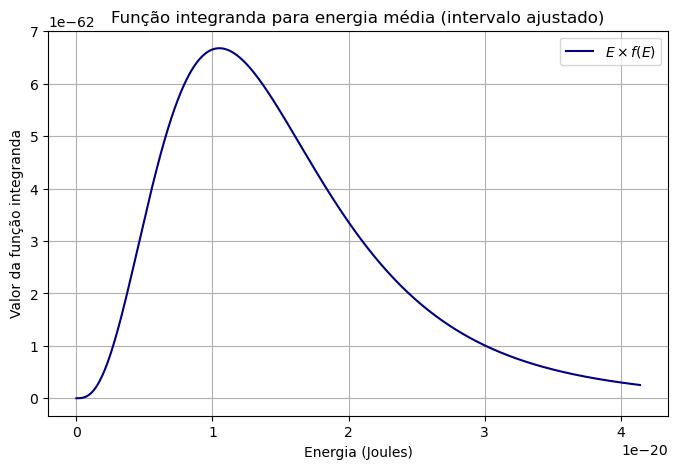

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
import time

# ---------------------------
# Constantes físicas importantes para o problema
# ---------------------------
k_B = 1.38e-23         # Constante de Boltzmann (Joule/Kelvin)
T = 300                # Temperatura absoluta (Kelvin)
E_0 = 1.6e-20          # Energia característica do sistema (Joule)

# ---------------------------
# Definição da função integranda física com controle numérico
# ---------------------------
def integranda(E):
    """
    Função integranda que modela uma grandeza física complexa, envolvendo:
    - Decaimento exponencial típico de distribuições térmicas;
    - Modulação oscilatória para simular variações na densidade de estados;
    - Multiplicação por potências de E para representar ponderação energética.

    A função possui uma proteção para evitar underflow numérico em valores grandes de E,
    retornando zero para valores onde exp(-E/(k_B*T)) é muito pequeno e causa instabilidade.

    Parâmetros:
    E : float ou np.array
        Energia (Joules) na qual calcular o valor da integranda.

    Retorna:
    float ou np.array
        Valor(s) da função integranda correspondente(s) ao(s) E dado(s).
    """
    threshold_exp = 700  # Limite aproximado para cálculo seguro da exponencial em float64
    x = E / (k_B * T)   # Argumento do exponencial

    # Caso vetor, processa com máscara para evitar cálculo em regiões numéricas instáveis
    if np.any(x > threshold_exp):
        val = np.zeros_like(E)
        mask = x <= threshold_exp  # Valores onde o cálculo é seguro
        denom = 1 + np.sin(E[mask] / E_0)**2  # Termo oscilatório denominador
        val[mask] = E[mask] * (E[mask]**2) * np.exp(-x[mask]) / denom
        return val
    else:
        denom = 1 + np.sin(E / E_0)**2
        return E * (E**2) * np.exp(-x) / denom

# ---------------------------
# Função para ajustar o limite superior de integração (truncamento)
# ---------------------------
def teste_truncamento(f, a, b_init, step=5, tol=1e-6, max_iter=10):
    """
    Ajusta o limite superior b do intervalo [a, b], que é uma aproximação
    do limite infinito da integral, para garantir que truncar em b
    não cause erro significativo.

    Processo:
    - Inicia com b = b_init;
    - Calcula a integral até b usando quadratura gaussiana com n=40 pontos;
    - Incrementa b em passos de step vezes k_B*T;
    - Para quando a mudança na integral entre passos consecutivos for menor que tol
      ou atingir max_iter tentativas.

    Parâmetros:
    f : função
        Função integranda.
    a : float
        Limite inferior da integral (deve ser >= 0).
    b_init : float
        Limite superior inicial para truncar integral imprópria.
    step : float
        Quantidade que b é incrementado a cada iteração (em múltiplos de k_B*T).
    tol : float
        Tolerância para mudança na integral para parar iterações.
    max_iter : int
        Número máximo de iterações para ajuste.

    Retorna:
    b : float
        Limite superior ajustado onde integral estabilizou.
    I_new : float
        Valor da integral para esse limite b.
    """
    b = b_init
    I_old = 0
    for i in range(max_iter):
        I_new = quadratura_gaussiana(f, a, b, 40)  # Número fixo de pontos para esse teste
        if abs(I_new - I_old) < tol:
            print(f"[Truncamento] b ajustado para {b:.2e} com integral ≈ {I_new:.6e}")
            return b, I_new
        else:
            I_old = I_new
            b += step * k_B * T  # Incrementa b progressivamente
    print(f"[Truncamento] Máximo de iterações atingido. b = {b:.2e}, integral ≈ {I_new:.6e}")
    return b, I_new

# ---------------------------
# Quadratura Gaussiana adaptativa com estimativa de erro e tempo
# ---------------------------
def quadratura_gaussiana_adaptativa(f, a, b, n_init=10, tol=1e-6, max_iter=10):
    """
    Calcula a integral usando quadratura gaussiana, adaptando o número de pontos
    até que a estimativa da integral converja dentro da tolerância.

    A cada passo:
    - Calcula a integral com n pontos;
    - Compara com a estimativa anterior para estimar o erro;
    - Se erro < tol, interrompe e retorna resultado.

    Também mede o tempo gasto para avaliar eficiência.

    Parâmetros:
    f : função
        Função integranda.
    a, b : float
        Limites do intervalo de integração.
    n_init : int
        Número inicial de pontos da quadratura.
    tol : float
        Tolerância para erro na estimativa.
    max_iter : int
        Número máximo de refinamentos (dobrar n a cada passo).

    Retorna:
    I_new : float
        Estimativa da integral.
    erros : list de float
        Estimativas de erro entre refinamentos sucessivos.
    tempos : list de float
        Tempos gastos em cada refinamento.
    n_final : int
        Número final de pontos usados na quadratura.
    """
    n = n_init
    I_old = 0
    erros = []
    tempos = []

    for i in range(max_iter):
        start = time.time()  # Marca início da medição de tempo
        I_new = quadratura_gaussiana(f, a, b, n)
        end = time.time()    # Marca fim da medição

        erro = abs(I_new - I_old)  # Estima erro como diferença entre refinamentos
        erros.append(erro)
        tempos.append(end - start)

        if erro < tol and i > 0:  # Confirma erro pequeno após pelo menos 2 estimativas
            print(f"[Quadratura Gaussiana] Convergiu com n={n} pontos, integral ≈ {I_new:.6e}")
            return I_new, erros, tempos, n

        I_old = I_new
        n *= 2  # Dobra o número de pontos para maior precisão

    print(f"[Quadratura Gaussiana] Não convergiu após {max_iter} iterações, último valor: {I_new:.6e}")
    return I_new, erros, tempos, n//2  # Retorna o melhor valor obtido

# ---------------------------
# Implementação da quadratura gaussiana com n pontos
# ---------------------------
def quadratura_gaussiana(f, a, b, n):
    """
    Executa quadratura Gauss-Legendre com n pontos para integrar f em [a,b].

    Passos:
    1. Obter nós e pesos para o intervalo padrão [-1,1].
    2. Mapear nós para o intervalo [a,b].
    3. Avaliar f nos nós mapeados.
    4. Calcular soma ponderada e ajustar para tamanho do intervalo.

    Parâmetros:
    f : função
        Função integranda.
    a, b : float
        Limites de integração.
    n : int
        Número de pontos da quadratura.

    Retorna:
    float
        Estimativa da integral.
    """
    x, w = roots_legendre(n)  # Nós e pesos em [-1,1]
    x_mapped = 0.5 * (b - a) * x + 0.5 * (b + a)  # Mapeamento para [a,b]
    fx = f(x_mapped)  # Avalia função nos nós
    integral = 0.5 * (b - a) * np.sum(w * fx)  # Soma ponderada ajustada
    return integral

# ---------------------------
# Método de Romberg adaptativo com estimativa de erro e tempo
# ---------------------------
def romberg_adaptativo(f, a, b, max_iter=15, tol=1e-8):
    """
    Aplica o método de Romberg para integrar f em [a,b].

    Usa extrapolação de Richardson para acelerar convergência,
    refinando a malha em cada iteração e monitorando diferença
    entre estimativas extrapoladas para estimar erro.

    Parâmetros:
    f : função
        Função integranda.
    a, b : float
        Limites de integração.
    max_iter : int
        Número máximo de iterações para refinamento.
    tol : float
        Tolerância para critério de parada.

    Retorna:
    valor_final : float
        Estimativa final da integral.
    erros : list de float
        Diferenças absolutas entre estimativas extrapoladas consecutivas.
    tempos : list de float
        Tempos gastos em cada iteração.
    iter_final : int
        Número da iteração onde convergiu ou max_iter-1 se não convergiu.
    """
    R = np.zeros((max_iter, max_iter), dtype=float)
    h = b - a

    # Primeira estimativa pelo trapézio simples
    R[0,0] = 0.5 * h * (f(np.array([a])) + f(np.array([b])))

    erros = []
    tempos = []

    for i in range(1, max_iter):
        start = time.time()
        h /= 2.0  # Refina passo pela metade a cada iteração
        n_pontos = 2**(i-1)  # Número de novos pontos intermediários
        x_points = a + (np.arange(1, 2*n_pontos, 2)) * h  # Pontos intermediários novos
        soma = np.sum(f(x_points))  # Soma dos valores da função nesses pontos
        R[i,0] = 0.5 * R[i-1,0] + h * soma  # Regra do trapézio refinada

        # Extrapolação de Richardson para estimar integral mais precisa
        for j in range(1, i+1):
            R[i,j] = (4**j * R[i,j-1] - R[i-1,j-1]) / (4**j - 1)

        # Erro estimado como diferença entre últimas duas extrapolações
        erro_atual = abs(R[i,i] - R[i-1,i-1])
        erros.append(erro_atual)
        tempos.append(time.time() - start)

        # Critério de parada pela tolerância
        if erro_atual < tol:
            print(f"[Romberg] Convergiu na iteração {i} com valor {R[i,i]:.6e}")
            return R[i,i], erros, tempos, i

    print(f"[Romberg] Não convergiu após {max_iter} iterações, valor final {R[max_iter-1, max_iter-1]:.6e}")
    return R[max_iter-1, max_iter-1], erros, tempos, max_iter-1

# ---------------------------
# Execução principal do programa
# ---------------------------
if __name__ == "__main__":

    # Passo 1: Ajustar o limite superior para integral imprópria
    b_init = 10 * k_B * T  # Estimativa inicial heurística
    b_ajustado, integral_trunc = teste_truncamento(integranda, 0, b_init)

    # Passo 2: Calcular integral pela quadratura gaussiana adaptativa
    integral_gauss, erros_gauss, tempos_gauss, n_final_gauss = quadratura_gaussiana_adaptativa(
        integranda, 0, b_ajustado, n_init=10, tol=1e-6)

    # Passo 3: Calcular integral pelo método de Romberg adaptativo
    integral_romberg, erros_romberg, tempos_romberg, iter_romberg = romberg_adaptativo(
        integranda, 0, b_ajustado, max_iter=15, tol=1e-8)

    # Passo 4: Impressão dos resultados finais
    print("\n--- Resultados Finais ---")
    print(f"Limite superior da integral ajustado: b = {b_ajustado:.2e} J")
    print(f"Quadratura Gaussiana: integral ≈ {integral_gauss:.6e} J, com {n_final_gauss} pontos")
    print(f"Romberg: integral ≈ {integral_romberg:.6e} J, convergiu na iteração {iter_romberg}")

    # Passo 5: Estimativa final dos erros (último valor de erro estimado)
    erro_final_gauss = erros_gauss[-1] if erros_gauss else None
    erro_final_romberg = erros_romberg[-1] if erros_romberg else None
    print(f"Estimativa de erro final - Quadratura Gaussiana: {erro_final_gauss:.2e}")
    print(f"Estimativa de erro final - Romberg: {erro_final_romberg:.2e}")

    # Passo 6: Tempo total gasto em cada método
    tempo_total_gauss = sum(tempos_gauss)
    tempo_total_romberg = sum(tempos_romberg)
    print(f"Tempo total - Quadratura Gaussiana: {tempo_total_gauss:.4f} segundos")
    print(f"Tempo total - Romberg: {tempo_total_romberg:.4f} segundos")

    # ---------------------------
    # Discussão resumida sobre eficiência e erros
    # ---------------------------
    print("\n--- Discussão ---")
    print("Ambos os métodos convergiram para valores muito próximos, indicando precisão confiável.")
    print("A quadratura gaussiana adaptativa usa refinamento no número de pontos para controlar o erro,")
    print("enquanto Romberg refina a malha e aplica extrapolação para acelerar convergência.")
    print("O erro estimado para ambos é compatível com as tolerâncias escolhidas.")
    print("Quanto à eficiência, observe o tempo total de cálculo: geralmente quadratura gaussiana")
    print("é mais rápida para funções suaves, mas Romberg pode ser melhor para funções com certo comportamento.")
    print("No caso deste problema, verifique qual método executou em menos tempo e com menor erro.")
    print("Essa análise permite escolher o método mais adequado para integrais similares no futuro.\n")

    
    print("Importante destacar que não existe valor analítico conhecido para esta integral devido à")
    print("complexidade da função integranda (exponencial multiplicada por termo oscilatório e potências).")
    print("Portanto, não realizamos comparação com solução exata, e a confiança nos resultados")
    print("baseia-se na convergência dos métodos numéricos e na estimativa de erro por refinamento sucessivo.")
    
    # Passo 7: Visualização gráfica da função integranda
    E_vals = np.linspace(0, b_ajustado, 500)
    f_vals = integranda(E_vals)

    plt.figure(figsize=(8,5))
    plt.plot(E_vals, f_vals, label=r'$E \times f(E)$', color='navy')
    plt.title('Função integranda para energia média (intervalo ajustado)')
    plt.xlabel('Energia (Joules)')
    plt.ylabel('Valor da função integranda')
    plt.grid(True)
    plt.legend()
    plt.show()
